This script is used to retreive all available NHM data from within the Delaware River Basin and store outputs as CSV files.

The method follows:
1.0 Get the IDs for all segments in the DRB
    1.1 Load the USGS geospatial fabric (GFv1.1) and DRB boundary
    1.2 Clip the GF using the boundary to identify all DRB relevant info.
2.0 Load and extract the NHM data of interest
    2.1 Load the .tar and get file members
    2.2 Extract files of interest
    2.3 Filter the data for DRB relevant values
3.0 Export CSVs



DATA:

The Geospatial Fabric (GFv1.1) data (1GB) is available here:
https://www.sciencebase.gov/catalog/item/5e29d1a0e4b0a79317cf7f63


The NHM-PRMS data must be downloaded here:
https://www.sciencebase.gov/catalog/item/5d826f6ae4b0c4f70d05913f

WARNING: The .tar file needed to retrieve NHM data is 92GB.  

In [6]:
import tarfile
import netCDF4 as nc
import xarray
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from nhm_drb_site_matches import nhm_site_matches

# Constants
cms_to_mgd = 22.82
cm_to_mg = 264.17/1e6
cfs_to_mgd = 0.64631688969744

In [2]:
# Load DRB and GF geospatial
crs = 4386
drb = gpd.read_file(f'../pywr/DRB_water_management/DRB_spatial/DRB_shapefiles/drb_bnd_polygon.shp').to_crs(crs)
gf = gpd.read_file(f'./GFv1.1.gdb/').to_crs(crs)
gf_poi = gpd.read_file(f'./gfv11/gfv11.shp').to_crs(crs)

# Load metadata
nhm_to_gf_hru = pd.read_csv('./data/nhm_to_GFv1.1_HRU.csv', sep =',')
nhm_to_gf_seg = pd.read_csv('./data/nhm_to_GFv1.1_SEG.csv', sep =',')

nhm_gage_ids = pd.read_csv("./data/poi_gage_id.csv", index_col=0)
nhm_seg_ids = pd.read_csv("./data/poi_gage_segment.csv", index_col=0)


nhm_gage_segments = pd.concat([nhm_gage_ids, nhm_seg_ids], axis=1)
nhm_gage_segments.columns = ['gage_id', 'nhm_segment_id']
nhm_gage_segments['gage_id'] = [f'0{site_id}' for site_id in nhm_gage_segments['gage_id'].values]


In [60]:
# Clip the GF to DRB
gf_drb = gpd.clip(gf, drb)
gf_poi_drb = gpd.clip(gf_poi, drb)

# Store DRB relevant segment IDs
drb_segment_ids = gf_drb['nsegment_v1_1']
drb_nhm_gage_segments = nhm_gage_segments.loc[nhm_gage_segments['nhm_segment_id'].isin(drb_segment_ids)]

<AxesSubplot: >

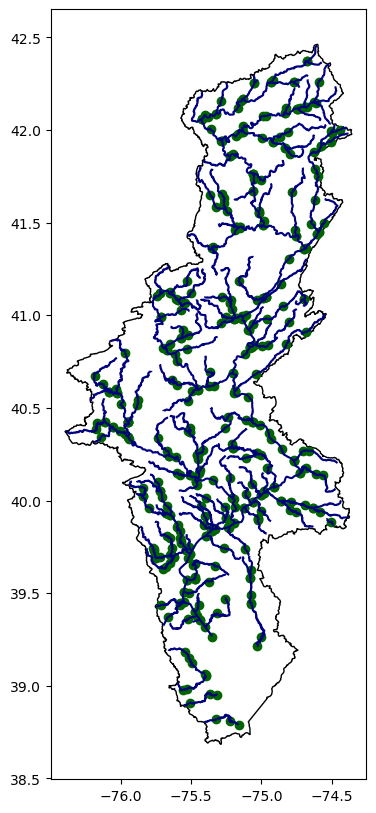

In [4]:
# Visualize the clip
ax = drb.plot(facecolor = 'none', edgecolor = 'black', figsize = (5,10))
gf_drb.plot(ax=ax, color = 'navy')
gf_poi_drb.plot(ax=ax, color = 'darkgreen')

In [161]:
## Load the NHM data
# .tar file location
re_extract = False
if re_extract:
    data_dir = 'C:/Users/tja73/Downloads'

    # Open and store file names
    tar = tarfile.open(f'{data_dir}/byHRU_musk_obs.tar')
    all_names = tar.getnames()
    all_members = tar.getmembers()

    # Extract just the NetCDF values of interest
    extract_member_indices = [7, 33, 36]
    extract_files = ['hru_outflow', 'seg_outflow', 'seg_upstream_inflow']

    for i in extract_member_indices:
        tar.extract(all_members[i], path = './outputs/')
    tar.close()

In [5]:
## HRU Outflow
hru_data = nc.Dataset(f'./outputs/netcdf/hru_outflow.nc')

# Store values
vals = hru_data['hru_outflow'][:]
hru_ids = hru_data['hru'][:]

# Make a dataframe
time_index = pd.date_range('1980-10-01', periods = 13241, freq = 'D')
hru_outflow_df = pd.DataFrame(vals, index = time_index, columns = hru_ids)

# Pull just DRB locations
drb_hru_outflow = hru_outflow_df.loc[:, drb_segment_ids]
drb_hru_outflow *= cfs_to_mgd

# Reformat
# drb_hru_outflow.index.name = 'Date'

drb_hru_outflow.to_csv('./outputs/csv/drb_hru_outflow_mgd.csv', sep = ',')
drb_hru_outflow.head(1)


In [16]:
## Segment Outflow
seg_data = nc.Dataset(f'./outputs/netcdf/seg_outflow.nc')

# Store values
vals = seg_data['seg_outflow'][:]
seg_ids = seg_data['segment'][:]

# Make a dataframe
time_index = pd.date_range('1980-10-01', periods = 13241, freq = 'D')
seg_outflow_df = pd.DataFrame(vals, index = time_index, columns = seg_ids)

# Pull just DRB locations
drb_seg_outflow = seg_outflow_df.loc[:, drb_segment_ids]
drb_seg_outflow *= cfs_to_mgd

# Export
drb_seg_outflow.to_csv('./outputs/csv/drb_seg_outflow_mgd.csv', sep = ',')


c:\Users\tja73\Desktop\Research\USGS_DRB\NHMv10\.venv\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


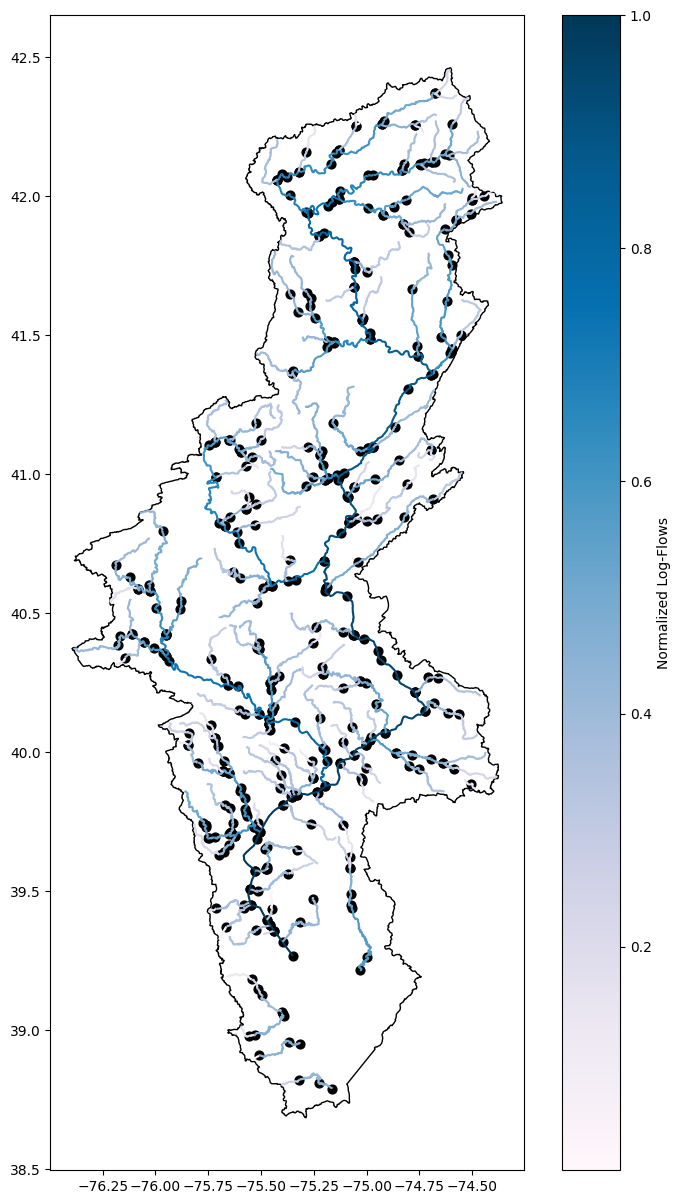

In [164]:
## Visualize NHM streamflow in DRB with flow-scale colors
# Define colormap using scaled log-flows
cmap = mpl.colormaps['PuBu']
log_flows = np.log(drb_seg_outflow).mean()
log_flows.loc[abs(log_flows) == np.inf] = 0
scale_flows = (log_flows - log_flows.min()) / (log_flows.max() - log_flows.min()) 
flow_colors = cmap(scale_flows)

# Plot
fig, ax = plt.subplots(figsize = (10,15))
drb.plot(facecolor = 'none', edgecolor = 'black', ax = ax)
points = gf_drb.plot(ax=ax, color = flow_colors)
gf_poi_drb.plot(ax=ax, color = 'black', markersize = 40)
sm = mpl.cm.ScalarMappable(cmap=cmap)
sm.set_array(flow_colors)
plt.colorbar(sm, ax=ax, label = "Normalized Log-Flows")
plt.savefig('./figures/drb_segment_scaled_flows.png', dpi = 300)
plt.show()

In [179]:
cannonsville_hrus = [1559, 1557, 1561, 1566, 1562]
pepacton = [1444, 1449, 1448]
neversink = []
assunpink_outlet = [1498, 1493]
christina = [2005, 2040]
merril = [1467, 1501]
shohola = [1588]
drb_seg_outflow.loc['1983-10-01':, shohola].median()

1588    57.991882
dtype: float64

In [17]:
drb_nhm_ids = gf_poi_drb.loc[:, ['prvdr_d', 'n2_REACHC', 'n2_COMI']]
drb_nhm_ids.columns = ['nhm_id', 'reachcode', 'comid']

# Add long-lat
drb_nhm_ids['long'] = gf_poi_drb.geometry.x
drb_nhm_ids['lat'] = gf_poi_drb.geometry.y

drb_nhm_ids = drb_nhm_ids.reset_index(inplace=False).drop(['index'], axis=1)
drb_nhm_ids.to_csv('./outputs/nhm_poi_ids.csv', sep = ',')

In [167]:
## Plotting the full geofabric
plot_full_streamnetwork = False

if plot_full_streamnetwork:
    gf_simplified = gf.simplify(tolerance = 0.01)

    style = 'default'
    plt.style.use(style)
    fig,ax = plt.subplots()
    gf_simplified.plot(ax=ax, linewidth= 0.2, color = 'black', rasterized=True)
    plt.axis('off')
    fig.set_size_inches(10, 6.25)
    plt.savefig(f'./figures/use_streams_{style}_simplified.svg', dpi = 300)
    plt.show()

I want to extract just the sites that are used in the Pywr-DRB model. 

To do this, I use the `nhm_site_matches` dictionary and pull out just those sites.

In [198]:
pywr_drb_sites = [i[0] for i in list(nhm_site_matches.values())]
pywr_drb_nhm_flows = drb_seg_outflow.loc[:, pywr_drb_sites]

pywr_drb_nhm_flows.to_csv(f'./outputs/csv/streamflow_daily_nhmv10_mgd.csv', sep = ',')

In [64]:
drb_nhm_gage_segments.to_csv('./outputs/drb_nhm_gage_segment_ids.csv', sep=',')

TypeError: to_csv() got an unexpected keyword argument 'dtype'